In [1]:
%matplotlib inline

In [2]:
# from __future__ import print_function
import time
import numpy as np
import argparse
import io
import os
import sys
import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d
from uncertainties import unumpy
import uncertainties as u
import itertools
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import scipy
import supplement as sp
import scipy.ndimage as ndimage

In [3]:
from jupyterthemes import jtplot
jtplot.style()

#### Initial Config

##### This segment will be setting initial color schemes and building mappings for heatmaps

In [4]:
experiment = '/Users/TRD/Research_Personal/Quant_Mo/data/aw_motion/'
light_e = '/Users/TRD/Research_Personal/Light-Barometer/data/elles/data/'
light_h = '/Users/TRD/Research_Personal/Light-Barometer/data/elles/filt/'
e_name = 'aw_motion'
l_nam = 'aw_light'
data = experiment + 'data'
pickled = experiment + 'pickled'
photos = experiment + 'photos'
filt = experiment + 'filt'
day = 'final'
color1 = '#bf5700'
color2 = '#808080'
rgb_color1 = mpl.colors.to_rgb(color1)
rgb_color2 = mpl.colors.to_rgb(color2)
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [rgb_color1, rgb_color2], N=100)

##### SETUP PROCESS - BUILDS DIRECTORY STRUCTURE

In [5]:
if os.path.exists(pickled) is False:
    os.makedirs(pickled)
if os.path.exists(photos) is False:
    os.makedirs(photos)
if os.path.exists(filt) is False:
    os.makedirs(filt)

In [6]:
plt.rcParams['figure.figsize'] = [13, 9]

#### Main Functions
-  main processing function which rebuilds the data into this system
-  edging function to remove heavy bias
-  normalization function

In [8]:
A = np.load('/Users/TRD/Research_Personal/Quant_Mo/data/aw_motion/filt/13aw_motion.npy')

In [37]:
print(A.shape)
A = sp.edge(A, (0.2, 0.74))

(35, 35, 2)


This function is looking to take something with an X and Y system to decompose it into a collapsed major system

In [10]:
print(A.shape)

(35, 35, 2)


In [ ]:
print()

In [14]:
A = sp.normalize(A)

#### Analysis
-  Primary look is with the aveerage motion across a segment of the array
-  Secondary is taylor series fit and fourier analysis
-  Third is brief display of quality of fit vs taylor size
-  Fourth is motion vector display
-  Fifth, sixth, seventh are gradient display (i.e. proportional to the "force")

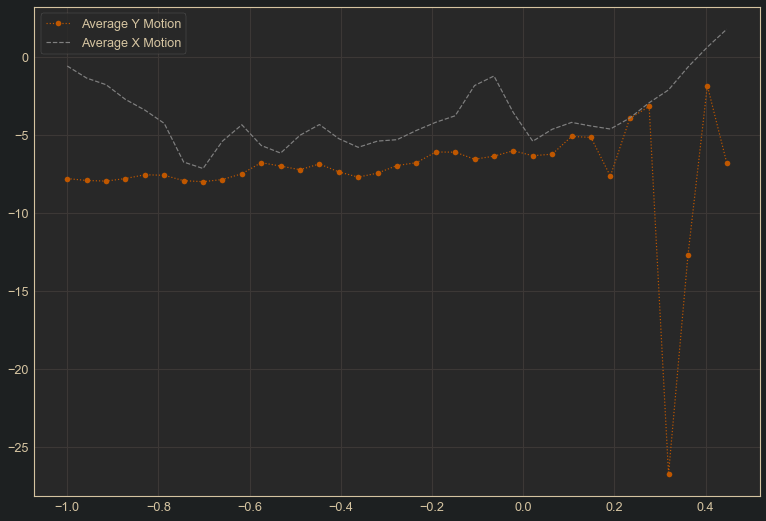

In [15]:
import matplotlib.pyplot as plt
X = np.linspace(np.min(A),np.max(A),num=A.shape[0])
y_motion = A[...,1]; x_motion = A[...,0];
y_avg = np.sum(y_motion, axis=1)
x_avg = np.sum(x_motion, axis=0)
max_val = np.max(y_motion.shape); min_val = 0
content = [X, y_avg, x_avg]
[X, y_avg, x_avg] = sp.floaty(*content)
plt.plot(X,y_avg,'o:', color=color1, label="Average Y Motion")
plt.plot(X,x_avg,'--', color=color2, label="Average X Motion")
plt.legend(loc='best')
plt.show()

/Users/TRD/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


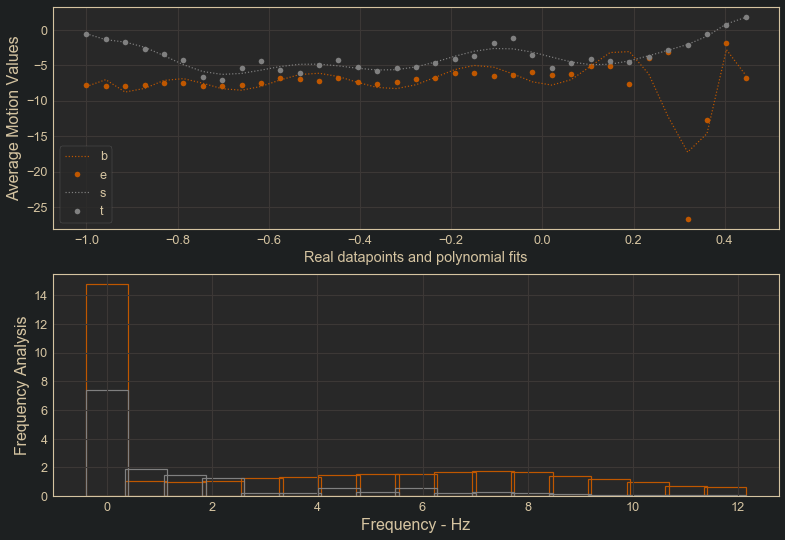

In [16]:
gs = gridspec.GridSpec(2,1, hspace=0.2)
fig = plt.figure()

poly_fit = 12
Vy = np.polyfit(X,y_avg,poly_fit)
Py = np.poly1d(Vy)
Vx = np.polyfit(X,x_avg,poly_fit)
Px = np.poly1d(Vx)

if y_avg.size == x_avg.size:
    N = y_avg.size;
else:
    raise

t = X[1]-X[0];

#first plot
ax = fig.add_subplot(gs[0])
ax.plot(X,Py(X),":", color=color1, label='Polyfit Terms'); ax.plot(X,y_avg,'o',color=color1, label="Average Motion Terms")
ax.plot(X,Px(X),":", color=color2, label='Polyfit Terms'); ax.plot(X,x_avg,'o',color=color2, label="Average Motion Terms")
ax.set_ylabel(r'Average Motion Values', size =16)
ax.set_xlabel(r'Real datapoints and polynomial fits')
ax.legend('best')

#second plot
ax = fig.add_subplot(gs[1])
fft_y = np.fft.fft(y_avg); fft_x = np.fft.fft(x_avg);
f = np.linspace(0.0, 1.0/(2.0*t), N/2)
ax.bar(f[:N], np.abs(fft_y)[:N // 2] * (2.0 / N), color=color1, fill=False, edgecolor=color1, linewidth=1.2)
ax.bar(f[:N], np.abs(fft_x)[:N // 2] * (2.0 / N), color=color2, fill=False, edgecolor=color2, linewidth=1.2)
ax.set_ylabel(r'Frequency Analysis', size =16)
ax.set_xlabel(r'Frequency - Hz', size =16)

plt.show()

In [17]:
residuals = []
test_range = 22
for i in range(test_range):
    Vy, residual, rank, singular_values, rcond = np.polyfit(X,y_avg,i,full=True)
    residuals.append(residual)
    
R = np.array(residuals)
R = R.flatten()
X_vals = np.array(range(test_range))

In [18]:
## This is a study on the variance over time of the system
var_evo = np.load(day+'_var.npy')
plt.plot(var_evo, color=color1)
plt.title("Study on the Variance over Time")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'final_var.npy'

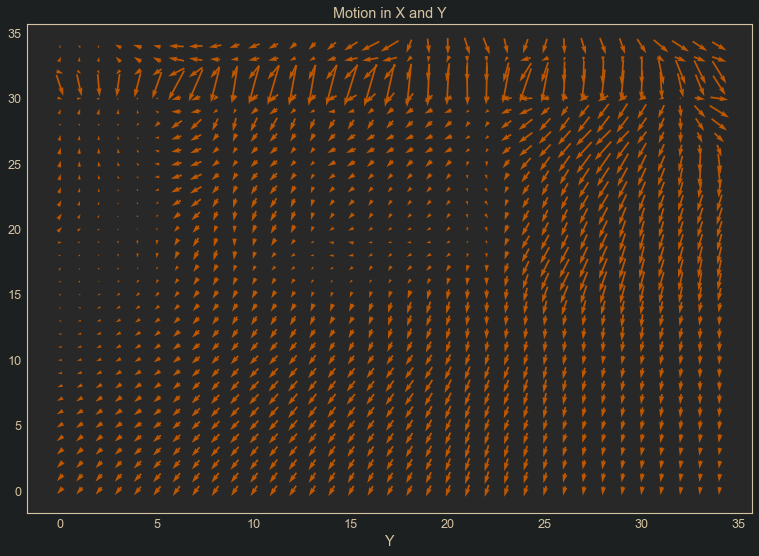

In [19]:
heat_x = np.linspace(np.min(A[0,...]), np.max(A[0,...]), num=A.shape[0])
heat_y = np.linspace(np.min(A[1,...]), np.max(A[1,...]), num=A.shape[1])
XX,YY = np.meshgrid(heat_x,heat_y)
plt.quiver(A[...,0],A[...,1], color=color1, pivot='mid')
plt.grid(False)
plt.title("Motion in X and Y")
plt.xlabel("X")
plt.xlabel("Y")
#sns.jointplot(A[0,...], kind="hex", color="#4CB391")
plt.show()

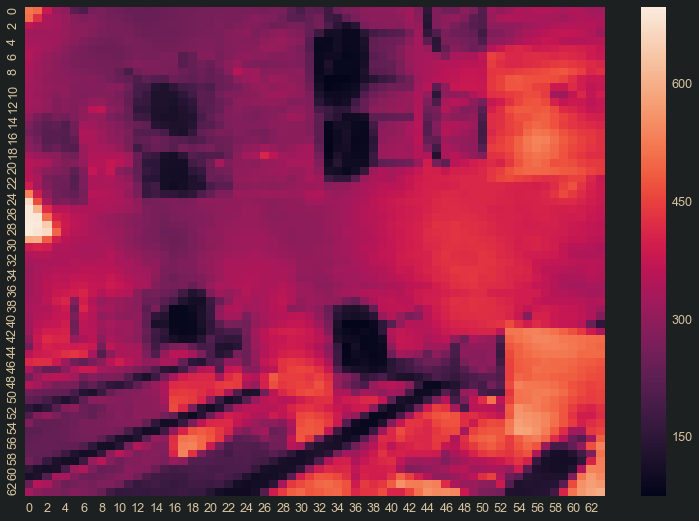

In [36]:
light_data = '/Users/TRD/Research_Personal/Quant_Mo/data/elles/filt/8aw_light.npy'
B = np.load(light_data)
sns.heatmap(np.rot90(B, k=1))

##### Now we're going to think for a bit about how the data evolves over time

In [68]:
sp.chunk_hours(data, filt)

['aw_motion!3@2018-08-15.00:06:40.npy'
 'aw_motion!3@2018-08-15.00:21:04.npy'
 'aw_motion!2@2018-08-14.00:16:39.npy'
 'aw_motion!1@2018-08-13.00:05:37.npy'
 'aw_motion!4@2018-08-16.00:20:10.npy'
 'aw_motion!4@2018-08-16.00:58:34.npy'
 'aw_motion!1@2018-08-13.00:08:49.npy'
 'aw_motion!1@2018-08-13.00:12:05.npy'
 'aw_motion!2@2018-08-14.00:20:12.npy'
 'aw_motion!4@2018-08-16.00:01:23.npy'
 'aw_motion!4@2018-08-16.00:23:57.npy'
 'aw_motion!4@2018-08-16.00:39:26.npy'
 'aw_motion!2@2018-08-14.00:05:46.npy'
 'aw_motion!1@2018-08-13.00:02:15.npy'
 'aw_motion!1@2018-08-13.00:03:55.npy'
 'aw_motion!1@2018-08-13.00:55:05.npy'
 'aw_motion!2@2018-08-14.00:23:46.npy'
 'aw_motion!4@2018-08-16.00:50:57.npy'
 'aw_motion!1@2018-08-13.00:23:34.npy'
 'aw_motion!2@2018-08-14.00:27:23.npy'
 'aw_motion!1@2018-08-13.00:56:45.npy'
 'aw_motion!1@2018-08-13.00:46:54.npy'
 'aw_motion!1@2018-08-13.00:13:43.npy'
 'aw_motion!2@2018-08-14.00:12:58.npy'
 'aw_motion!1@2018-08-13.00:33:33.npy'
 'aw_motion!1@2018-08-13.

['aw_motion!3@2018-08-15.05:33:22.npy'
 'aw_motion!2@2018-08-14.05:00:50.npy'
 'aw_motion!3@2018-08-15.05:15:24.npy'
 'aw_motion!3@2018-08-15.05:29:51.npy'
 'aw_motion!2@2018-08-14.05:51:08.npy'
 'aw_motion!2@2018-08-14.05:36:54.npy'
 'aw_motion!2@2018-08-14.05:22:35.npy'
 'aw_motion!3@2018-08-15.05:55:28.npy'
 'aw_motion!3@2018-08-15.05:26:05.npy'
 'aw_motion!2@2018-08-14.05:47:41.npy'
 'aw_motion!2@2018-08-14.05:44:10.npy'
 'aw_motion!4@2018-08-16.05:30:22.npy'
 'aw_motion!4@2018-08-16.05:11:07.npy'
 'aw_motion!4@2018-08-16.05:22:36.npy'
 'aw_motion!3@2018-08-15.05:11:46.npy'
 'aw_motion!3@2018-08-15.05:59:02.npy'
 'aw_motion!1@2018-08-13.05:37:17.npy'
 'aw_motion!4@2018-08-16.05:57:08.npy'
 'aw_motion!3@2018-08-15.05:00:59.npy'
 'aw_motion!2@2018-08-14.05:33:15.npy'
 'aw_motion!3@2018-08-15.05:40:45.npy'
 'aw_motion!3@2018-08-15.05:36:59.npy'
 'aw_motion!4@2018-08-16.05:37:58.npy'
 'aw_motion!2@2018-08-14.05:18:52.npy'
 'aw_motion!1@2018-08-13.05:41:21.npy'
 'aw_motion!3@2018-08-15.

['aw_motion!3@2018-10-03.10:17:04.npy'
 'aw_motion!5@2018-09-07.10:53:46.npy'
 'aw_motion!5@2018-08-24.10:28:55.npy'
 'aw_motion!5@2018-08-31.10:20:18.npy'
 'aw_motion!6@2018-09-08.10:43:59.npy'
 'aw_motion!7@2018-09-23.10:34:01.npy'
 'aw_motion!3@2018-09-26.10:43:54.npy'
 'aw_motion!5@2018-09-21.10:17:32.npy'
 'aw_motion!3@2018-09-19.10:08:10.npy'
 'aw_motion!3@2018-09-12.10:15:21.npy'
 'aw_motion!6@2018-09-29.10:19:39.npy'
 'aw_motion!1@2018-09-24.10:51:53.npy'
 'aw_motion!5@2018-08-17.10:04:01.npy'
 'aw_motion!3@2018-08-15.10:54:30.npy'
 'aw_motion!6@2018-10-06.10:18:33.npy'
 'aw_motion!4@2018-08-16.10:09:14.npy'
 'aw_motion!4@2018-09-20.10:48:07.npy'
 'aw_motion!5@2018-10-05.10:23:20.npy'
 'aw_motion!1@2018-09-17.10:01:47.npy'
 'aw_motion!3@2018-10-03.10:53:40.npy'
 'aw_motion!7@2018-08-26.10:04:23.npy'
 'aw_motion!7@2018-10-07.10:21:22.npy'
 'aw_motion!4@2018-10-04.10:35:05.npy'
 'aw_motion!5@2018-09-07.10:45:36.npy'
 'aw_motion!6@2018-09-01.10:39:17.npy'
 'aw_motion!4@2018-09-13.

['aw_motion!6@2018-09-15.15:16:02.npy'
 'aw_motion!1@2018-09-17.15:24:09.npy'
 'aw_motion!5@2018-09-14.15:48:57.npy'
 'aw_motion!4@2018-08-30.15:59:26.npy'
 'aw_motion!3@2018-09-05.15:46:54.npy'
 'aw_motion!2@2018-10-02.15:04:22.npy'
 'aw_motion!2@2018-08-14.15:09:27.npy'
 'aw_motion!5@2018-09-14.15:45:03.npy'
 'aw_motion!2@2018-08-28.15:09:42.npy'
 'aw_motion!4@2018-09-13.15:35:11.npy'
 'aw_motion!5@2018-09-07.15:07:08.npy'
 'aw_motion!7@2018-08-19.15:04:55.npy'
 'aw_motion!2@2018-08-21.15:52:01.npy'
 'aw_motion!3@2018-08-22.15:25:12.npy'
 'aw_motion!1@2018-09-24.15:36:38.npy'
 'aw_motion!1@2018-08-13.15:16:29.npy'
 'aw_motion!1@2018-09-03.15:22:52.npy'
 'aw_motion!7@2018-08-26.15:29:35.npy'
 'aw_motion!2@2018-08-21.15:19:28.npy'
 'aw_motion!4@2018-09-06.15:28:41.npy'
 'aw_motion!2@2018-08-21.15:31:29.npy'
 'aw_motion!3@2018-08-15.15:46:03.npy'
 'aw_motion!1@2018-10-01.15:24:29.npy'
 'aw_motion!1@2018-08-13.15:12:58.npy'
 'aw_motion!4@2018-09-27.15:39:09.npy'
 'aw_motion!1@2018-08-20.

['aw_motion!1@2018-08-13.19:07:31.npy'
 'aw_motion!1@2018-08-13.19:56:54.npy'
 'aw_motion!1@2018-08-13.19:38:02.npy'
 'aw_motion!1@2018-08-13.19:00:06.npy'
 'aw_motion!2@2018-08-14.19:06:38.npy'
 'aw_motion!3@2018-08-15.19:57:08.npy'
 'aw_motion!3@2018-08-15.19:12:24.npy'
 'aw_motion!2@2018-08-14.19:42:55.npy'
 'aw_motion!3@2018-08-15.19:32:54.npy'
 'aw_motion!1@2018-08-13.19:15:21.npy'
 'aw_motion!1@2018-08-13.19:22:49.npy'
 'aw_motion!1@2018-08-13.19:03:44.npy'
 'aw_motion!3@2018-08-15.19:24:40.npy'
 'aw_motion!1@2018-08-13.19:53:07.npy'
 'aw_motion!1@2018-08-13.19:11:22.npy'
 'aw_motion!3@2018-08-15.19:16:26.npy'
 'aw_motion!2@2018-08-14.19:58:42.npy'
 'aw_motion!3@2018-08-15.19:08:32.npy'
 'aw_motion!3@2018-08-15.19:04:33.npy'
 'aw_motion!2@2018-08-14.19:54:53.npy'
 'aw_motion!2@2018-08-14.19:46:52.npy'
 'aw_motion!3@2018-08-15.19:20:35.npy'
 'aw_motion!3@2018-08-15.19:36:44.npy'
 'aw_motion!2@2018-08-14.19:30:55.npy'
 'aw_motion!3@2018-08-15.19:28:49.npy'
 'aw_motion!3@2018-08-15.

In [69]:
motion_files = [f for f in os.listdir(data) if os.path.isfile(os.path.join(data, f))]

##### First thing we try to do is read a pickled file with the same hourly value to avoid extra processing

In [70]:
# Hour of interest here:
hour = 7
h = str(hour); h_b = str(hour-1); h_a = str(hour+1)
f_name = filt+'/'+h+e_name+'.npy'
l_name = light_h+h+l_nam+'.npy'
f_before = filt+'/'+h_b+e_name+'.npy'
f_after = filt+'/'+h_a+e_name+'.npy'
M = np.load(f_name); # This should always work if the line before was run
L = np.load(l_name);

# This is going to load the motion arrays for the hour before and after if they're avaliable
try:
    M_b = np.load(f_before)
except IOError as e:
    M_b = np.zeros_like(M)
    
try:
    M_a = np.load(f_after)
except IOError as e:
    M_a = np.zeros_like(M)

Max val is: 0.00740814208984375
Max val is: 0.206298828125


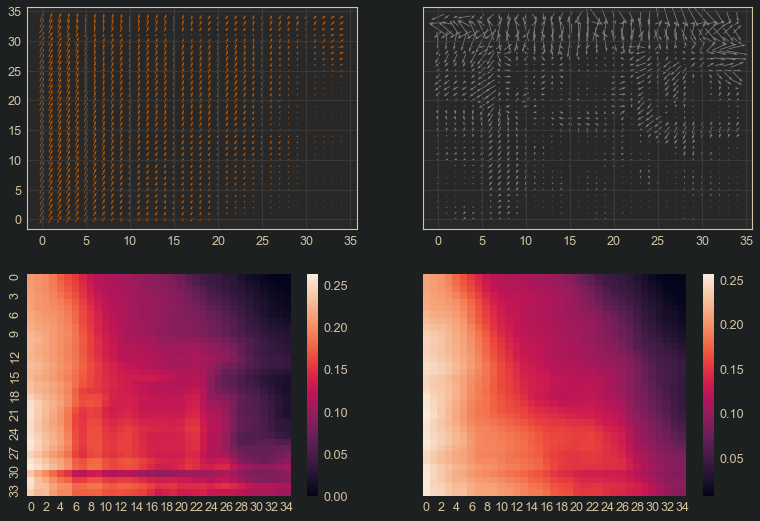

In [94]:
fig, axe = plt.subplots(2, 2, sharey='row')

MM_b = M - M_b; MM_a = M - M_a;
MM_bb = MM_b / my_max
MM_aa = MM_a / my_max
print("Max val is: {}".format(np.max(MM_b)))
print("Max val is: {}".format(np.max(MM_bb)))

e1 = 0.2; e2 = 0.74;
Mo = sp.edge(M, (e1,e2)); MM_bb = sp.edge(MM_bb, (e1,e2)); MM_aa = sp.edge(MM_aa, (e1,e2));
Gx, Gy, Gz = np.gradient(Mo); GG = Gx+Gy
axe[0][0].quiver(Mo[...,0],Mo[...,1], color='#bf5700', pivot='mid')
axe[0][1].quiver(GG[...,0],GG[...,1], color='grey', pivot='mid')
# Going to make this the difference between the last hour and this hour
sns.heatmap(np.sum(MM_bb,axis=2), color=color2, ax=axe[1, 0])
sns.heatmap(np.sum(MM_aa,axis=2), color=color2, ax=axe[1, 1])
axe[1][1].invert_yaxis()
axe[1][0].invert_yaxis()

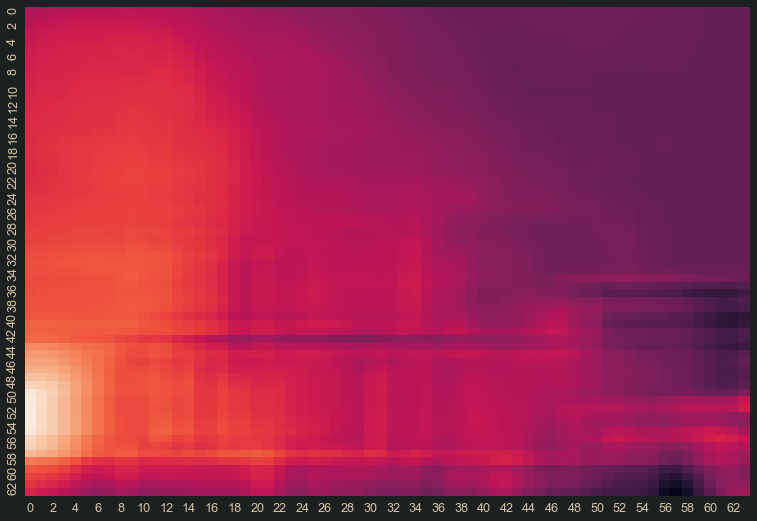

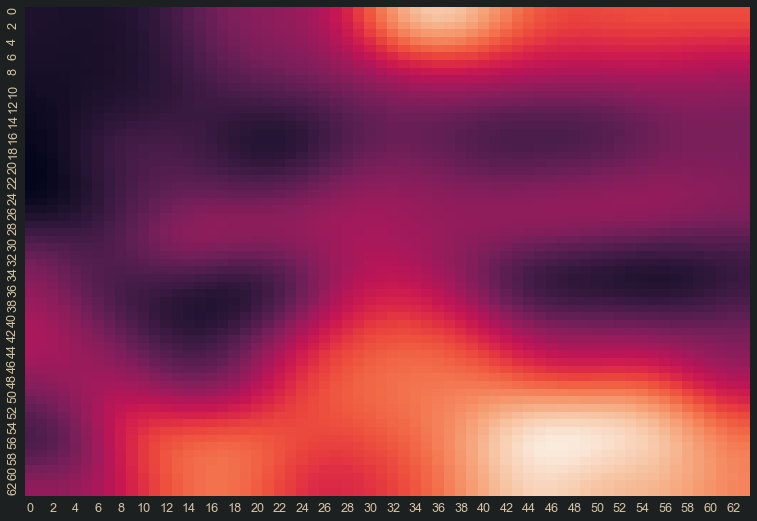

In [92]:
e1 = 0.2; e2 = 0.74;
Mo = sp.edge(M, (e1,e2))
Gx, Gy, Gz = np.gradient(M); GG = Gx+Gy
sns.heatmap(np.sum(M,axis=2), color=color2, cbar=False)
plt.show()
# axe[0].quiver(M[...,0],M[...,1], color='grey', pivot='mid')
# Going to make this the difference between the last hour and this hour
L_blur = ndimage.gaussian_filter(L.astype('int'), sigma=(4, 4), order=0)
sns.heatmap(L_blur, color=color2, cbar=False)
plt.show()

#plt.imshow(arr, cmap='gray')
axe[0].invert_yaxis()


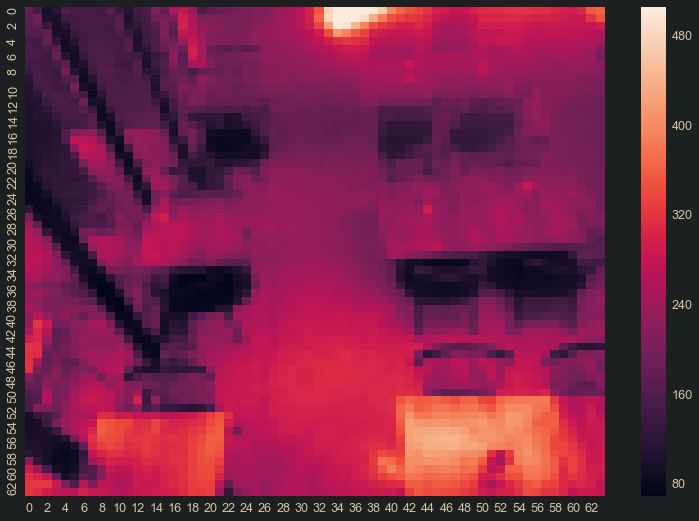

In [54]:
sns.heatmap(L)

In [23]:
## This is where I can study the light patterns on the time period

In [24]:
l_files = os.listdir(light_e)
print("The length of the files is: {}".format(len(l_files)))
fl_files = [ light_e+i for i in l_files ]
l_vals = np.array([])
for i in fl_files:
    a = np.load(i, encoding='latin1')
    avg = np.average(a[2])
    l_vals = np.append(arr=l_vals, values=avg)

tee = [ i.strip('.npy').split('@',1)[-1] for i in l_files ]
light = pd.DataFrame({'filename': fl_files,'date': tee})
light['date'] = pd.to_datetime(light['date'], format='%Y-%m-%d.%H:%M:%S')
light['hour'] = pd.DatetimeIndex(light['date']).hour
light['intensity'] = l_vals

The length of the files is: 956


/Users/TRD/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


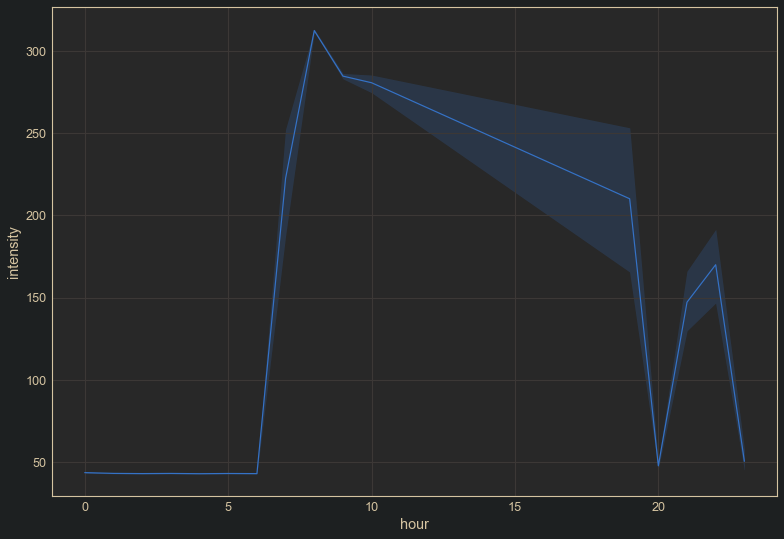

In [25]:
sns.lineplot(x='hour',y='intensity',data=light)

### This is a study on the time variance

In [26]:
## This is going to collect our pickled data
lt_motion = pd.read_pickle(pickled+'/aw_motion_save.pkl')

In [27]:
lt_motion['minute'] = pd.DatetimeIndex(lt_motion['Date']).minute
lt_motion['month'] = pd.DatetimeIndex(lt_motion['Date']).month
lt_motion['hour'] = pd.DatetimeIndex(lt_motion['Date']).hour